In [ ]:
# Install the necessary libraries
!pip install PyPortfolioOpt #Library to perform portfolio optimization
!pip install yfinance #Library to download financial data
!pip install forex-python #Library to download forex data

## Comparison of Modern Portfolio Theory returns and risk models on given set of stocks
The idea is to compare the different portfolios that are created as a result of different combinations of returns and risk models.
There are many models available for both returns and risk.

For returns, I will look at the following:
 - Mean historical returns
 - Exponentially weighted mean of historical returns
 - Returns based on CAPM

For risk models, I will look at the following:
 - Sample covariance
 - Ledoit-Wolf with 3 different shrinkage targets
    - Constant variance
    - Single factor
    - Constant correlation

This results in 3x4 = 12 different portfolios to be compared.








### Step 1: Pick a portfolio to balance
As a starting point I have chosen the following stocks inspired by my friend's portfolio:

- Frontline (FRO.OL): NOK (listed on the Oslo Stock Exchange)
- Nordea Bank Abp (NDA-FI.HE): EUR (listed on the Helsinki Stock Exchange)
- BAWAG Group AG (BG.VI): EUR (listed on the Vienna Stock Exchange)
- CaixaBank (CABK.MC): EUR (listed on the Madrid Stock Exchange)
- Danske Bank (DANSKE.CO): DKK (listed on the Copenhagen Stock Exchange)
- McDonald’s (MCD): USD (listed on the NYSE)


### Step 2: Read in price data

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
# Ticker symbols for the chosen stocks
tickers = ['FRO.OL', 'NDA-FI.HE', 'BG.VI', 'CABK.MC', 'DANSKE.CO', 'MCD']

# Download historical data for the specified tickers from Yahoo Finance
stock_data = yf.download(tickers, start='2008-01-01', end='2024-09-10')

# Extract the adjusted close prices, which we are interested in for the analysis
stock_prices = stock_data['Adj Close'].reset_index()
stock_prices.columns.name = None
stock_prices.set_index('Date', drop = True, inplace = True)
display(stock_prices.tail()) #Display the 5 latest prices for the chosen time period

[*********************100%***********************]  6 of 6 completed


,BG.VI,CABK.MC,DANSKE.CO,FRO.OL,MCD,NDA-FI.HE
Date,,,,,,
2024-09-03 00:00:00+00:00,67.599998,5.310,208.399994,243.567825,285.519989,10.615
2024-09-04 00:00:00+00:00,68.500000,5.288,210.399994,241.273773,288.029999,10.515
2024-09-05 00:00:00+00:00,70.900002,5.374,209.699997,238.082062,287.970001,10.685
2024-09-06 00:00:00+00:00,69.099998,5.318,207.699997,241.572998,289.510010,10.435
2024-09-09 00:00:00+00:00,69.500000,5.428,206.600006,236.785431,291.290009,10.585


### Step 3: Calculate or provide expected returns

A seasoned trader might have their own, custom calculations for expected returns.
I am not seasoned nor seer, so I will compare the available methods from PyPortfolioOpt.

The methods are:
1. The traditional expected returns based on the mean of historical returns
2. Exponentially weighting the mean of historical returns to emphasize recent results
3. Expected returns based on Capital Asset Pricing Model (I have used the 10 year US treasury bond giving a risk free rate of 3.65% as a benchmark)

All of these can use either geometric or arithmetic mean. I have chosen to look at geometric mean as it accounts for compounding.

In [28]:
from pypfopt import EfficientFrontier 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import BlackLittermanModel

# Calculate expected returns and sample covariance
mu_mean = expected_returns.mean_historical_return(stock_prices) # Annualised mean historical return
mu_ema = expected_returns.ema_historical_return(stock_prices, span=1500) # Annualised return using exponentially weighted mean
mu_capm = expected_returns.capm_return(stock_prices, risk_free_rate=0.0365) # Annualized returns calculated based on CAPM with risk free rate of 3.65%

/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-lea

Plotting a heatmap of annualized returns gives me a better idea of what the expected returns are for each method, so we can decide which method to proceed with.

Looking at the heatmap below it is clear that the market has been very kind for the last 1500 days (the span that the exponentially weighted mean is based on). I am nothing if not an optimist, so we will proceed using this expected return.

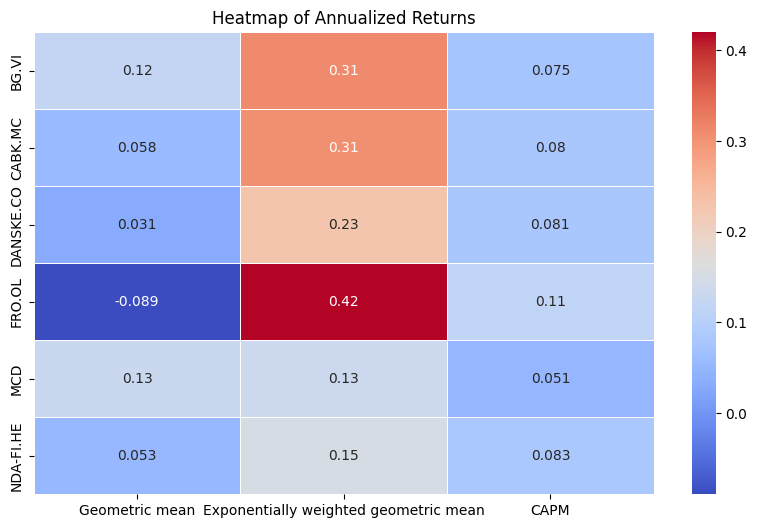

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine Series into a DataFrame
data = pd.DataFrame({
    'Geometric mean': mu_mean,
    'Exponentially weighted geometric mean': mu_ema,
    'CAPM': mu_capm
})

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Annualized Returns')
plt.show()


### Step 4: Calculate portfolio variance

Picking the right risk model for calculating portfolio variance is a science in itself.
The text book option would be to use the sample covariance as the risk model.
However, 

In [30]:
# Set up different risk models
S_sample_cov = risk_models.sample_cov(stock_prices) # Sample covariance
S_LW_cv = risk_models.CovarianceShrinkage(stock_prices).ledoit_wolf(shrinkage_target='constant_variance') # Ledoit-Wolf with constant variance as shrinkage target
S_LW_sf = risk_models.CovarianceShrinkage(stock_prices).ledoit_wolf(shrinkage_target='single_factor') # Ledoit-Wolf with single factor(identity matrix) as shrinkage target
S_LW_cc = risk_models.CovarianceShrinkage(stock_prices).ledoit_wolf(shrinkage_target='constant_correlation') # Ledoit-Wolf with constant correlation as shrinkage target

/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-lea

### Step 5: Optimize for maximal Sharpe ratio using different risk models

There are several different optimizations one can chose in Modern Portfolio Theory.
1. Minimize volatility a.k.a. playing it as safe as possible
2. Maximize return for a given risk a.k.a. you know your limits
3. Minimize risk for a given target return a.k.a. you know what you need to pay your mortgage
4. Maximize Sharpe ratio a.k.a. as much return as possible with no unnecessary risk

I know my friend is gamling man, which is why I'll be looking to maximize the Sharpe ratio.

Here is an overview of 

- Portfolio 1 is exponentially weighted mean of historical returns X sample covariance
- Portfolio 2 is exponentially weighted mean of historical returns X Ledoit-Wolf constant variance
- Portfolio 3 is exponentially weighted mean of historical returns X Ledoit-Wolf single factor
- Portfolio 4 is exponentially weighted mean of historical returns X Ledoit-Wolf constant correlation

#### ef5

In [39]:
# Optimize for maximal Sharpe ratio
ef5 = EfficientFrontier(mu_ema, S_sample_cov) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef5.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef5_raw_weights = ef5.max_sharpe(risk_free_rate=0.0365)
ef5_cleaned_weights = ef5.clean_weights()
# ef5.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef5_cleaned_weights)
ef5.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.34857, 'CABK.MC': 0.22648, 'DANSKE.CO': 0.03575, 'FRO.OL': 0.17154, 'MCD': 0.21766, 'NDA-FI.HE': 0.0})
Expected annual return: 28.7%
Annual volatility: 23.3%
Sharpe Ratio: 1.07


/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.28679648583549017, 0.2329678474396496, 1.0743821028793665)

#### ef6

In [40]:
# Optimize for maximal Sharpe ratio
ef6 = EfficientFrontier(mu_ema, S_LW_cv) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef6.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef6_raw_weights = ef6.max_sharpe(risk_free_rate=0.0365)
ef6_cleaned_weights = ef6.clean_weights()
# ef6.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef6_cleaned_weights)
ef6.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.68225, 'CABK.MC': 0.10383, 'DANSKE.CO': 0.00595, 'FRO.OL': 0.10348, 'MCD': 0.10449, 'NDA-FI.HE': 0.0})
Expected annual return: 30.3%
Annual volatility: 18.4%
Sharpe Ratio: 1.45


(0.3030858068975653, 0.1841626512518814, 1.4475563046328697)

#### ef9

In [41]:
# Optimize for maximal Sharpe ratio
ef9 = EfficientFrontier(mu_ema, S_LW_sf) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef9.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef9_raw_weights = ef9.max_sharpe(risk_free_rate=0.0365)
ef9_cleaned_weights = ef9.clean_weights()
# ef9.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef9_cleaned_weights)
ef9.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.68921, 'CABK.MC': 0.10098, 'DANSKE.CO': 0.0038, 'FRO.OL': 0.10242, 'MCD': 0.1036, 'NDA-FI.HE': 0.0})
Expected annual return: 30.3%
Annual volatility: 18.4%
Sharpe Ratio: 1.45


(0.3033308625493298, 0.18377579631525548, 1.4519369138882616)

#### ef10

In [42]:
# Optimize for maximal Sharpe ratio
ef10 = EfficientFrontier(mu_ema, S_LW_cc) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef10.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef10_raw_weights = ef10.max_sharpe(risk_free_rate=0.0365)
ef10_cleaned_weights = ef10.clean_weights()
# ef10.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef10_cleaned_weights)
ef10.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.34874, 'CABK.MC': 0.22831, 'DANSKE.CO': 0.03667, 'FRO.OL': 0.17072, 'MCD': 0.21556, 'NDA-FI.HE': 0.0})
Expected annual return: 28.7%
Annual volatility: 23.3%
Sharpe Ratio: 1.07


(0.28699373864109046, 0.23333821018472314, 1.0735221567131508)

### Step 5: Compare the different portfolios

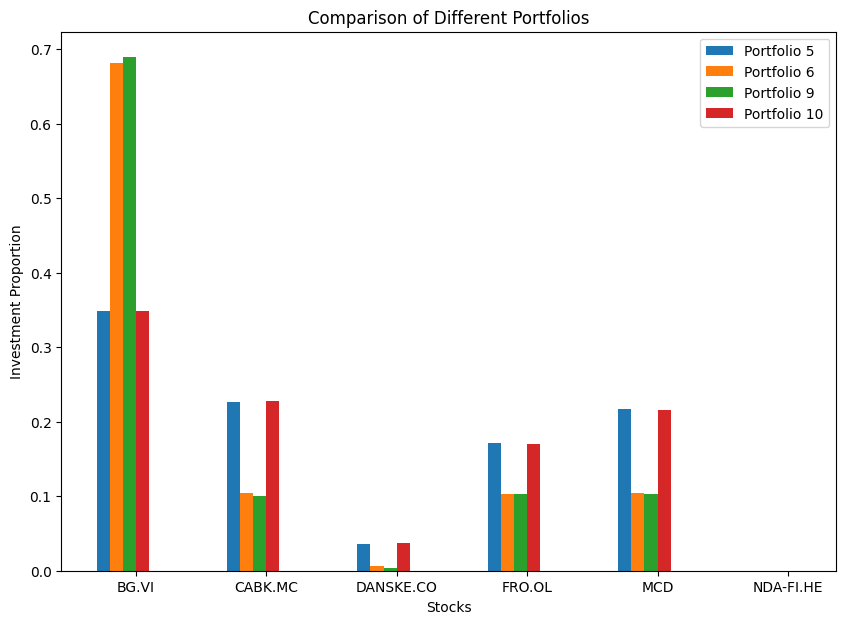

In [43]:
import matplotlib.pyplot as plt
from collections import OrderedDict

portfolios = {
    'Portfolio 5': ef5_cleaned_weights,
    'Portfolio 6': ef6_cleaned_weights,
    'Portfolio 9': ef9_cleaned_weights,
    'Portfolio 10': ef10_cleaned_weights
}

# Stock labels
stocks = list(ef5_cleaned_weights.keys())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each portfolio as a bar chart
for i, (portfolio_name, values) in enumerate(portfolios.items()):
    ax.bar([x + i*0.1 for x in range(len(stocks))], values.values(), width=0.1, label=portfolio_name)

# Set the x-axis labels
ax.set_xticks([x + 0.25 for x in range(len(stocks))])
ax.set_xticklabels(stocks)

# Set the labels and title
ax.set_xlabel('Stocks')
ax.set_ylabel('Investment Proportion')
ax.set_title('Comparison of Different Portfolios')

# Add a legend
ax.legend()

# Show the plot
plt.show()
